In [ ]:
%load_ext autoreload
%autoreload 2

from nocap.models import clip_model_dict, ImageCaptioner, model_config
from nocap.utils import get_device, get_wandb_checkpoint_path
import torch
from nocap.dataset import Flickr30k
import matplotlib.pyplot as plt

class ImageCaptionerAPI:
    def __init__(self, model_dict, model_config, wandb_checkpoint, device):
        checkpoint_path = get_wandb_checkpoint_path(
            wandb_checkpoint,
        )

        model = ImageCaptioner(model_dict, model_config)
        # Load the model
        checkpoint = torch.load(
            checkpoint_path,
            map_location=device, 
            weights_only=True,
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model

    def run_inference(self, image):
        """ Image is torch.Tensor
        """
        caption = None
        # captioner.model.image_processor(val_ds[0][0], return_tensors='pt')
        image_inputs = self.model.image_processor(
            images=image,
            return_tensors='pt',
        )
        x = image_inputs['pixel_values']

        # Greedy search
        # TODO: implement beam_search
        generated = torch.tensor(
            [[self.model.bos_id]], dtype=torch.int32, device=x.device,
        )
        for _ in range(self.model.text_seq_len_max - generated.size(1)):
            # assume outputs.logits [1, T, V]
            test_scores = self.model.forward(x, generated)
            # 3) Greedy pick at last position
            next_token = torch.argmax(
                test_scores[:, -1, :], dim=-1, keepdim=True,
            )  # [1,1]
            # 4) Append and check EOS
            generated = torch.cat([generated, next_token], dim=1)  # [1, T+1]
            if next_token.item() == self.model.eos_id:
                break
        
        caption = captioner.model.text_tokenizer.decode(generated[0][1:-1])
        return caption

captioner = ImageCaptionerAPI(clip_model_dict, 
                model_config, 
                'kwokkenton-individual/mlx-week4-image-captioning/transformer_captioner:v31',
                device = torch.device('cpu'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb: Downloading large artifact transformer_captioner:v31, 945.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4


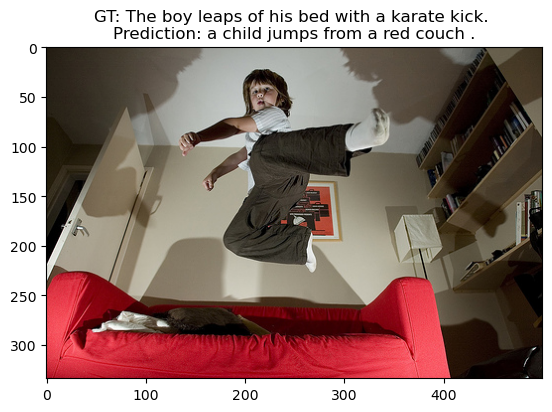

In [57]:
import random

val_ds = Flickr30k(split='val')
choice = random.randint(0, len(val_ds) -1 )
im, target = val_ds[choice]
plt.imshow(im.permute(1,2,0))
plt.title(f'GT: {target} \nPrediction: {captioner.run_inference(im)}')
plt.show()

In [ ]:
captioner.run_inference(im)